In [1]:
from transformers import AutoTokenizer
from rouge import Rouge
from nltk.corpus import stopwords
from nltk.util import ngrams
import nltk
import re
import pandas as pd
import numpy as np
from collections import Counter
import whisper
import librosa
import os
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import requests
import tarfile

# 1. Data Loading

In [2]:
# adjust display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# URL for the dev-clean dataset
url = "https://www.openslr.org/resources/12/dev-clean.tar.gz"
dataset_dir = "data/"
tar_path = os.path.join(dataset_dir, "dev-clean.tar.gz")

os.makedirs(dataset_dir, exist_ok=True)

# Download the dataset 
if not os.path.exists(tar_path):
    response = requests.get(url, stream=True)
    with open(tar_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)

In [4]:
# extract the dataset
extract_path = os.path.join(dataset_dir, "LibriSpeech")
if not os.path.exists(extract_path):
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=dataset_dir)

In [5]:
# function to get audio paths
def get_audio_paths(root_dir):
    audio_paths = []
    for dirpath, _, filenames in os.walk(root_dir):
        for file in filenames:
            if file.endswith(".flac"):
                audio_paths.append(os.path.join(dirpath, file))
    return audio_paths

In [6]:
# function to get transcript
transcript_cache = {}

def get_transcript(flac_path):
    dir_path = os.path.dirname(flac_path)
    file_id = os.path.splitext(os.path.basename(flac_path))[0]

    if dir_path not in transcript_cache:
        trans_file = [f for f in os.listdir(dir_path) if f.endswith(".trans.txt")]
        if not trans_file:
            return ""
        trans_path = os.path.join(dir_path, trans_file[0])
        with open(trans_path, "r") as f:
            lines = f.readlines()

        transcript_cache[dir_path] = {
            line.split(" ", 1)[0]: line.split(" ", 1)[1].strip() for line in lines
        }

    return transcript_cache[dir_path].get(file_id, "")

In [7]:
root_dir = "data/LibriSpeech/dev-clean"
audio_paths = get_audio_paths(root_dir)

data = []
for path in audio_paths:
    duration = librosa.get_duration(filename=path)
    transcript = get_transcript(path)
    data.append({'file': path, 'duration': duration, 'text': transcript})

data = pd.DataFrame(data)

data.head()

/var/folders/bj/kty340bx2c5fb8txjv7svs8r0000gn/T/ipykernel_97495/2812042897.py:6: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=path)


,file,duration,text
0,data/LibriSpeech/dev-clean/2412/153954/2412-153954-0019.flac,7.485,BUT BY AND BY THEY CAME TO MY WATCH WHICH I HAD HIDDEN AWAY IN THE INMOST POCKET THAT I HAD AND HAD FORGOTTEN WHEN THEY BEGAN THEIR SEARCH
1,data/LibriSpeech/dev-clean/2412/153954/2412-153954-0023.flac,2.650,THIS HAD SOME EFFECT IN CALMING HIM
2,data/LibriSpeech/dev-clean/2412/153954/2412-153954-0015.flac,11.390,SUFFICE IT THAT I FOUND MYSELF TAKEN BEFORE THE CHIEF MAGISTRATE AND BY HIS ORDERS WAS PLACED IN AN APARTMENT WITH TWO OTHER PEOPLE WHO WERE THE FIRST I HAD SEEN LOOKING ANYTHING BUT WELL AND HANDSOME
3,data/LibriSpeech/dev-clean/2412/153954/2412-153954-0003.flac,8.150,THE VINE GREW OUTSIDE MANY OF THE HOUSES AND THERE WERE SOME WITH SIGN BOARDS ON WHICH WAS PAINTED A BOTTLE AND A GLASS THAT MADE ME FEEL MUCH AT HOME
4,data/LibriSpeech/dev-clean/2412/153954/2412-153954-0002.flac,4.055,THE STREETS WERE NARROW AND UNPAVED BUT VERY FAIRLY CLEAN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2703 entries, 0 to 2702
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   file      2703 non-null   object 
 1   duration  2703 non-null   float64
 2   text      2703 non-null   object 
dtypes: float64(1), object(2)
memory usage: 63.5+ KB


# 2. Exploratory Data Analysis

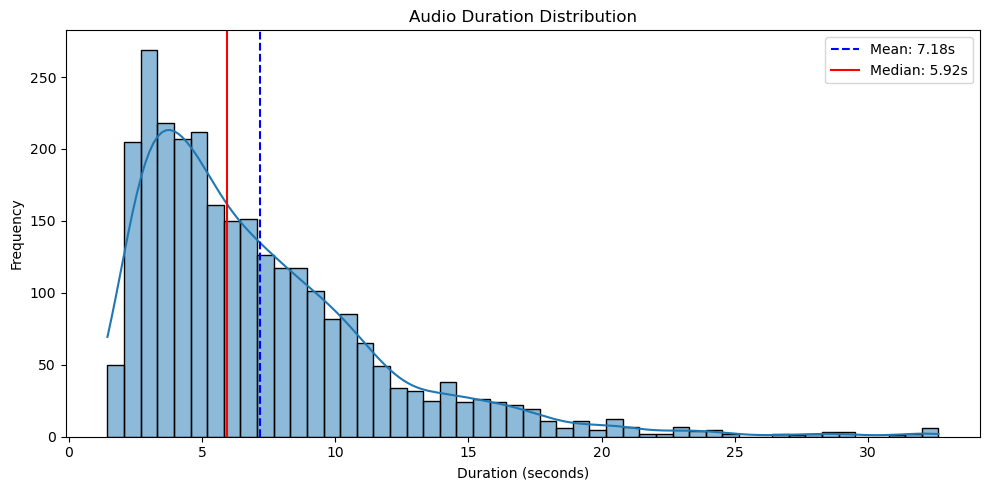

In [9]:
# histogram of audio durations
mean_duration = data['duration'].mean()
median_duration = data['duration'].median()

plt.figure(figsize=(10, 5))
sns.histplot(data['duration'], bins=50, kde=True)

plt.axvline(mean_duration, color='blue', linestyle='--', label=f'Mean: {mean_duration:.2f}s')
plt.axvline(median_duration, color='red', linestyle='-', label=f'Median: {median_duration:.2f}s')

plt.title('Audio Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [10]:
data.describe()

,duration
count,2703.000000
mean,7.175775
std,4.695612
min,1.445000
25%,3.760000
50%,5.920000
75%,9.267500
max,32.645000


In [11]:
# use bert model to compute token length of text
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
data['token_length'] = data['text'].apply(lambda x: len(tokenizer.tokenize(x)))

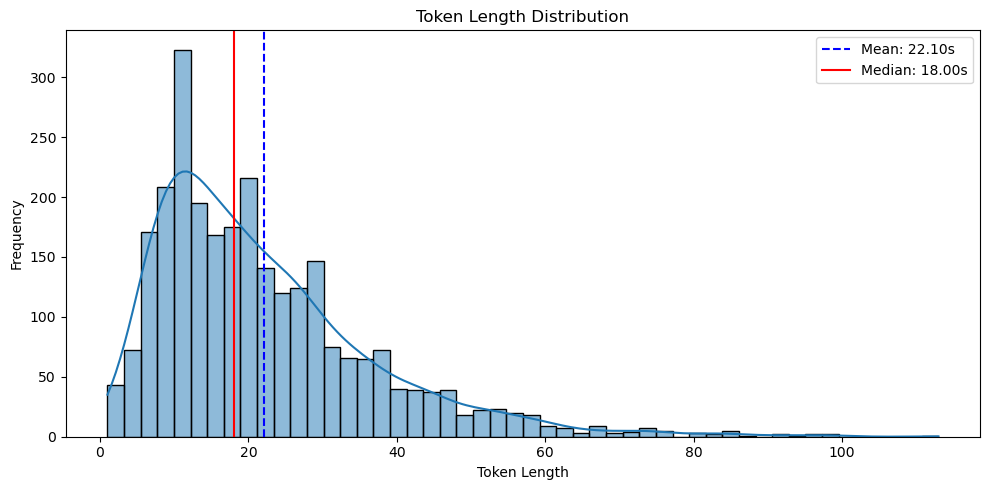

In [12]:
# histogram of token lengths
mean_token_length = data['token_length'].mean()
median_token_length = data['token_length'].median()

plt.figure(figsize=(10, 5))
sns.histplot(data['token_length'], bins=50, kde=True)

plt.axvline(mean_token_length, color='blue', linestyle='--', label=f'Mean: {mean_token_length:.2f}s')
plt.axvline(median_token_length, color='red', linestyle='-', label=f'Median: {median_token_length:.2f}s')

plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

# 3. Speech to Text

In [ ]:
# use OpenAI Whisper model
model = whisper.load_model("base")
transcriptions = []

# Loop through each file and transcribe
for path in tqdm(data['file'], desc="Transcribing audio"):
    try:
        result = model.transcribe(path)
        transcriptions.append(result['text'])
    except Exception as e:
        print(f"Error transcribing {path}: {e}")
        transcriptions.append("")

# Add transcriptions to DataFrame
data['whisper_text'] = transcriptions

In [20]:
data.to_csv("data/dev_clean.csv", index=False)

In [21]:
data = pd.read_csv("data/dev_clean.csv")

In [22]:
data.head()

,file,duration,text,token_length,whisper_text
0,Data/dev-clean/dev-clean/2412/153954/2412-153954-0019.flac,7.485,BUT BY AND BY THEY CAME TO MY WATCH WHICH I HAD HIDDEN AWAY IN THE INMOST POCKET THAT I HAD AND HAD FORGOTTEN WHEN THEY BEGAN THEIR SEARCH,30,"But by and by they came to my watch, which I had hidden away in the inn most pocket that I had and had forgotten when they began their search."
1,Data/dev-clean/dev-clean/2412/153954/2412-153954-0023.flac,2.650,THIS HAD SOME EFFECT IN CALMING HIM,7,This had some effect in calming him.
2,Data/dev-clean/dev-clean/2412/153954/2412-153954-0015.flac,11.390,SUFFICE IT THAT I FOUND MYSELF TAKEN BEFORE THE CHIEF MAGISTRATE AND BY HIS ORDERS WAS PLACED IN AN APARTMENT WITH TWO OTHER PEOPLE WHO WERE THE FIRST I HAD SEEN LOOKING ANYTHING BUT WELL AND HANDSOME,39,"Suffice it that I found myself taken before the chief magistrate, and by his orders was placed in an apartment with two other people. Who were the first I had seen looking anything but well in handsome."
3,Data/dev-clean/dev-clean/2412/153954/2412-153954-0003.flac,8.150,THE VINE GREW OUTSIDE MANY OF THE HOUSES AND THERE WERE SOME WITH SIGN BOARDS ON WHICH WAS PAINTED A BOTTLE AND A GLASS THAT MADE ME FEEL MUCH AT HOME,31,The vine grew outside many of the houses and there were some with signboards on which was painted a bottle and a glass that made me feel much at home
4,Data/dev-clean/dev-clean/2412/153954/2412-153954-0002.flac,4.055,THE STREETS WERE NARROW AND UNPAVED BUT VERY FAIRLY CLEAN,12,The streets were narrow and unpaid but very fairly clean.


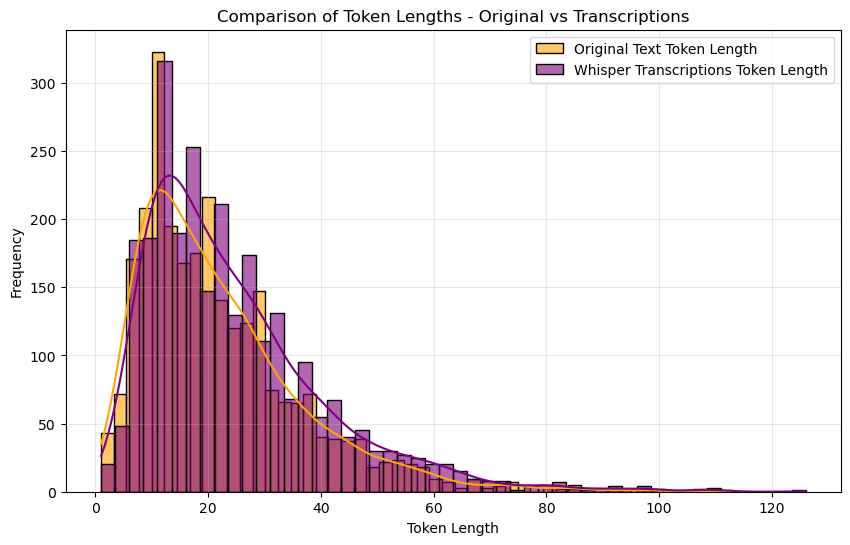

In [23]:
# Comparison of token lengths between original text and Whisper transcriptions
plt.figure(figsize=(10, 6))
sns.histplot(data["token_length"], bins=50, color='orange', label="Original Text Token Length", kde=True, alpha=0.6)
sns.histplot(data['whisper_text'].apply(lambda x: len(tokenizer.tokenize(x))), bins=50, color='purple', label="Whisper Transcriptions Token Length", kde=True, alpha=0.6)
plt.title("Comparison of Token Lengths - Original vs Transcriptions")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

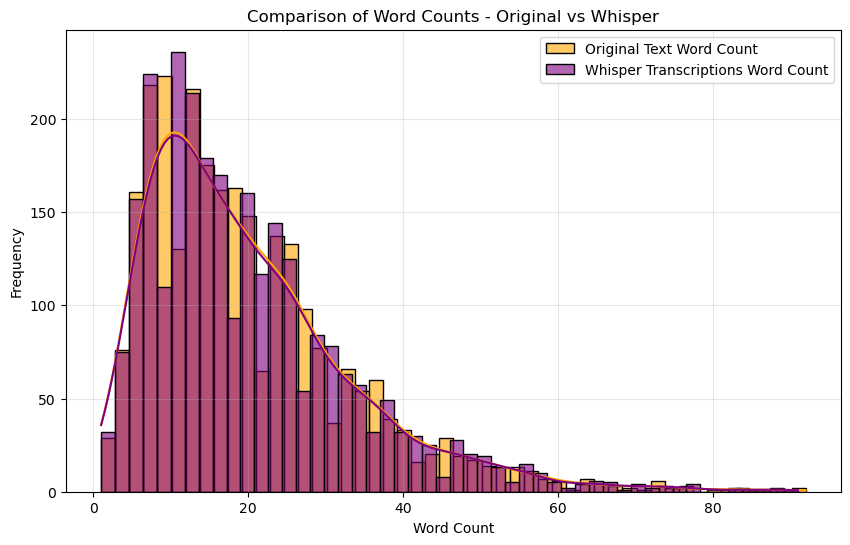

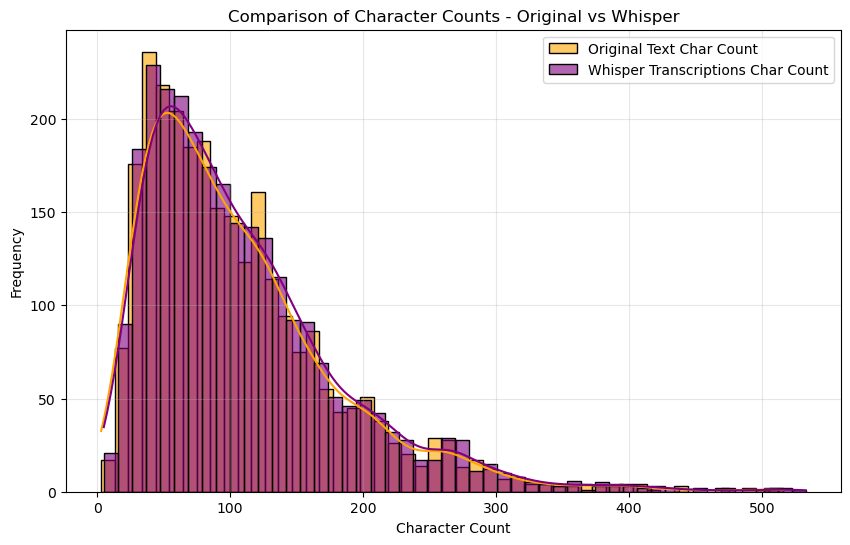

In [24]:
# Comparison of character counts and word counts between original text and Whisper transcriptions
data["text_word_count"] = data["text"].apply(lambda x: len(str(x).split()))
data["text_char_count"] = data["text"].apply(lambda x: len(str(x)))

data["whisper_word_count"] = data["whisper_text"].apply(lambda x: len(str(x).split()))
data["whisper_char_count"] = data["whisper_text"].apply(lambda x: len(str(x)))

# Comparison of Word Counts
plt.figure(figsize=(10, 6))
sns.histplot(data["text_word_count"], bins=50, color='orange', label="Original Text Word Count", kde=True, alpha=0.6)
sns.histplot(data["whisper_word_count"], bins=50, color='purple', label="Whisper Transcriptions Word Count", kde=True, alpha=0.6)
plt.title("Comparison of Word Counts - Original vs Whisper")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Comparison of Character Counts
plt.figure(figsize=(10, 6))
sns.histplot(data["text_char_count"], bins=50, color='orange', label="Original Text Char Count", kde=True, alpha=0.6)
sns.histplot(data["whisper_char_count"], bins=50, color='purple', label="Whisper Transcriptions Char Count", kde=True, alpha=0.6)
plt.title("Comparison of Character Counts - Original vs Whisper")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

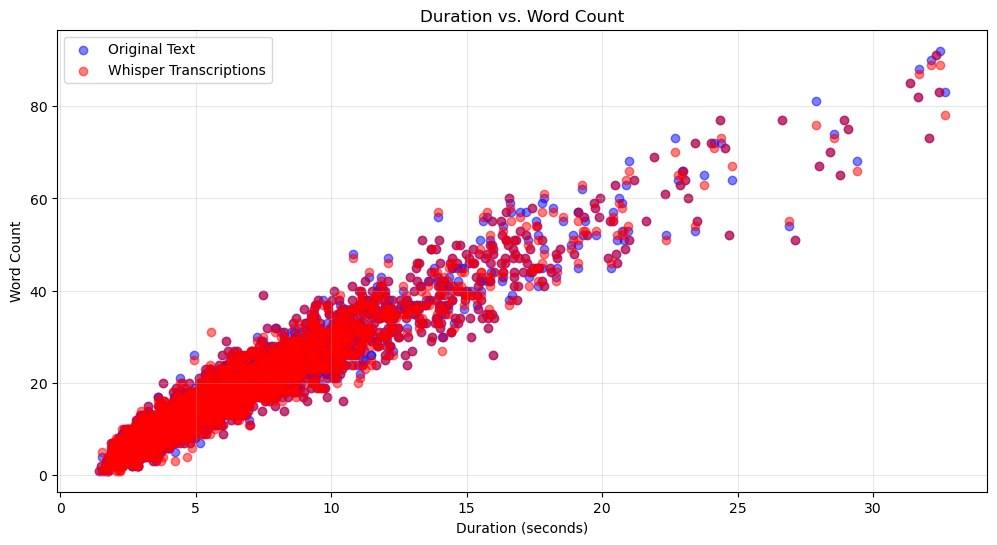

Correlation between Duration and Original Word Count: 0.96
Correlation between Duration and Whisper Word Count: 0.96


In [25]:
# Scatter Plot: Duration vs. Word Count
plt.figure(figsize=(12, 6))
plt.scatter(data["duration"], data["text_word_count"], alpha=0.5, label="Original Text", color='blue')
plt.scatter(data["duration"], data["whisper_word_count"], alpha=0.5, label="Whisper Transcriptions", color='red')
plt.title("Duration vs. Word Count")
plt.xlabel("Duration (seconds)")
plt.ylabel("Word Count")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Correlation Analysis
correlation = data["duration"].corr(data["text_word_count"])
print(f"Correlation between Duration and Original Word Count: {correlation:.2f}")

correlation_whisper = data["duration"].corr(data["whisper_word_count"])
print(f"Correlation between Duration and Whisper Word Count: {correlation_whisper:.2f}")

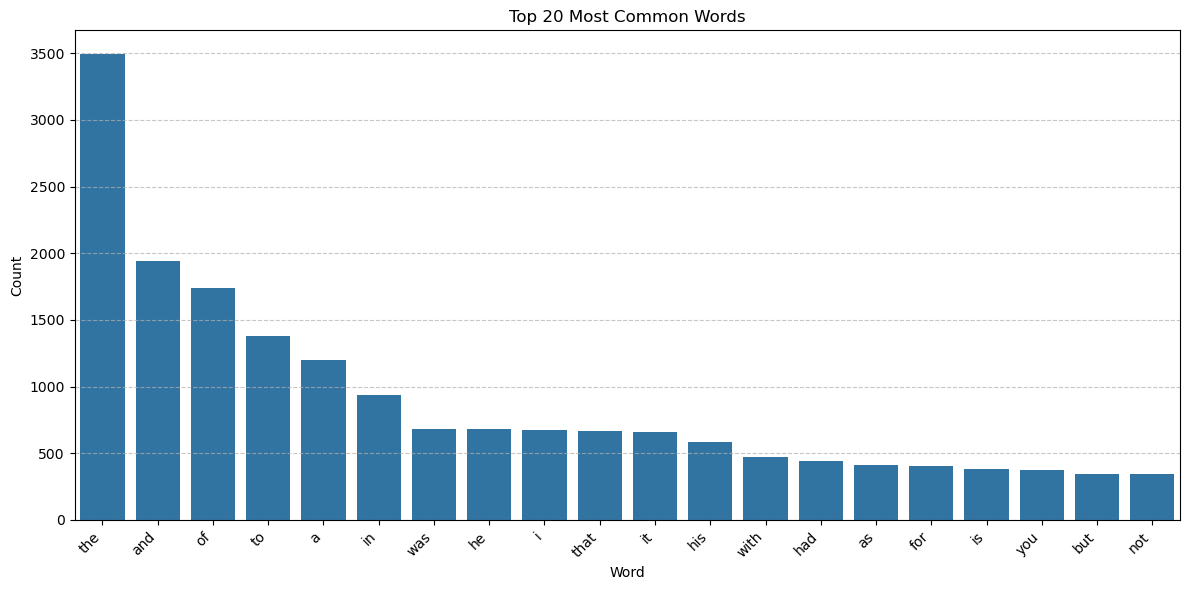

In [26]:
# Identifying the most common words
all_text = " ".join(data["whisper_text"].dropna().tolist()).lower()

# Tokenize and count words
words = re.findall(r'\b\w+\b', all_text)
word_counts = Counter(words)

common_words = word_counts.most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Count', data=common_words_df)
plt.title("Top 20 Most Common Words")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fuqianzou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


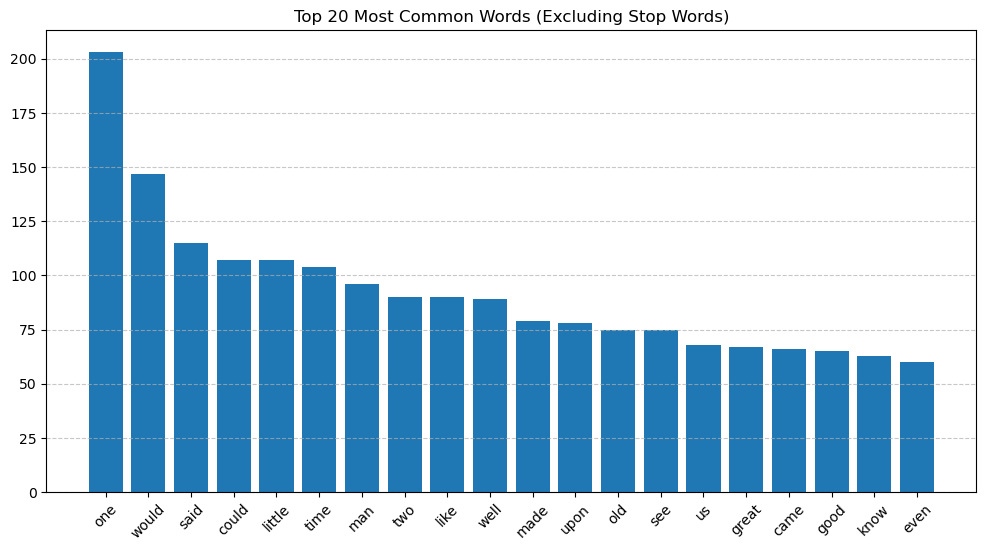

In [27]:
# Identifying the most common words excluding stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

all_text = " ".join(data["whisper_text"].dropna().tolist()).lower()

# Tokenize and count words excluding stopwords
words = re.findall(r'\b\w+\b', all_text)
filtered_words = [word for word in words if word not in stop_words]
word_counts = Counter(filtered_words)

common_words = word_counts.most_common(20)

plt.figure(figsize=(12, 6))
plt.bar(*zip(*common_words))
plt.title("Top 20 Most Common Words (Excluding Stop Words)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Top 20 Bi-grams (excluding stop words): [(('could', 'see'), 10), (('two', 'three'), 8), (('one', 'another'), 7), (('old', 'man'), 7), (('every', 'man'), 6), (('lady', 'lady'), 6), (('would', 'go'), 6), (('mode', 'put'), 5), (('one', 'two'), 5), (('two', 'days'), 5), (('died', 'away'), 5), (('know', 'said'), 5), (('first', 'time'), 5), (('one', 'side'), 5), (('good', 'opinion'), 5), (('wandering', 'singer'), 5), (('emperor', 'daughter'), 5), (('young', 'man'), 5), (('green', 'box'), 5), (('mary', 'ann'), 5)]


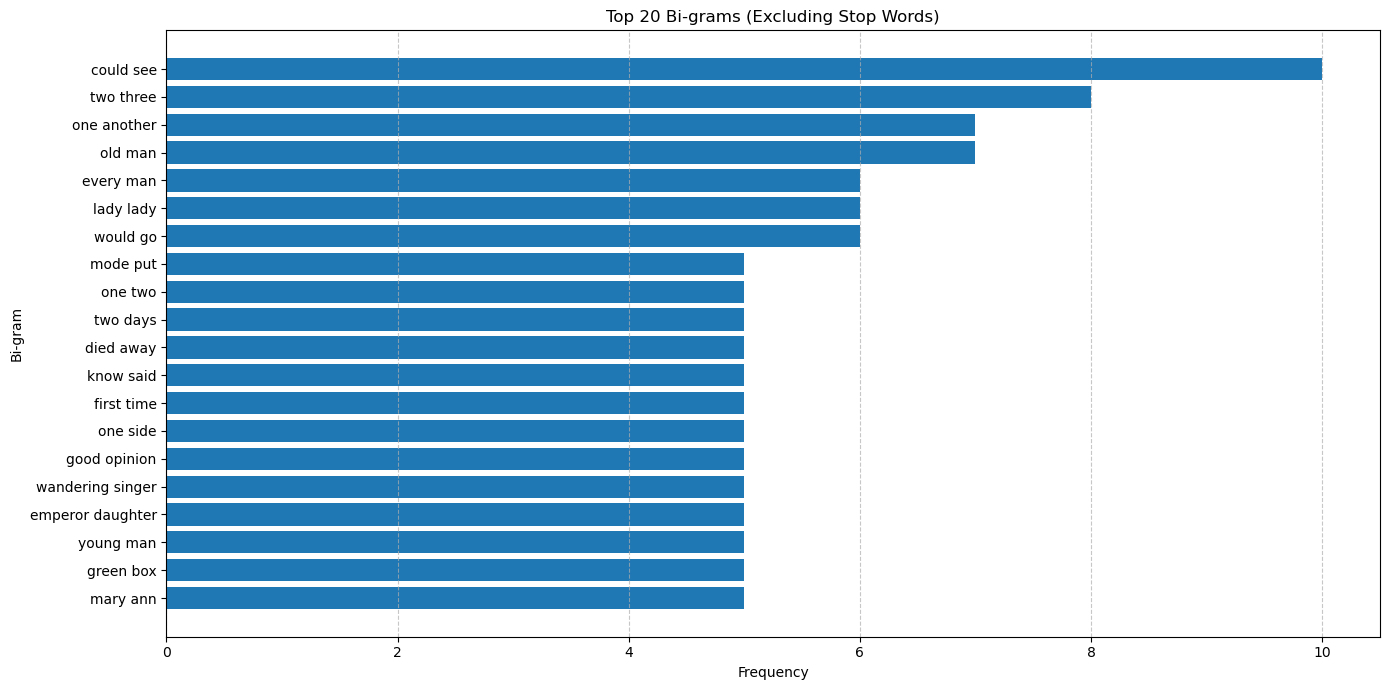

In [28]:
# Identify top bi-grams
all_text = " ".join(data["whisper_text"].dropna().tolist()).lower()

# Tokenize and remove stop words
words = re.findall(r'\b\w+\b', all_text)
filtered_words = [word for word in words if word not in stop_words]

# Generate bi-grams
bigrams = list(ngrams(filtered_words, 2))

# Count bi-grams
bigram_counts = Counter(bigrams)

top_bigrams = bigram_counts.most_common(20)
print("Top 20 Bi-grams (excluding stop words):", top_bigrams)

plt.figure(figsize=(14, 7))
plt.barh([' '.join(bigram) for bigram, _ in top_bigrams], [count for _, count in top_bigrams])
plt.title("Top 20 Bi-grams (Excluding Stop Words)")
plt.xlabel("Frequency")
plt.ylabel("Bi-gram")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [29]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

In [30]:
# clean text
data['cleaned_text'] = data['text'].apply(clean_text)
data['cleaned_whisper_text'] = data['whisper_text'].apply(clean_text)

data.head()

,file,duration,text,token_length,whisper_text,text_word_count,text_char_count,whisper_word_count,whisper_char_count,cleaned_text,cleaned_whisper_text
0,Data/dev-clean/dev-clean/2412/153954/2412-153954-0019.flac,7.485,BUT BY AND BY THEY CAME TO MY WATCH WHICH I HAD HIDDEN AWAY IN THE INMOST POCKET THAT I HAD AND HAD FORGOTTEN WHEN THEY BEGAN THEIR SEARCH,30,"But by and by they came to my watch, which I had hidden away in the inn most pocket that I had and had forgotten when they began their search.",29,138,30,143,but by and by they came to my watch which i had hidden away in the inmost pocket that i had and had forgotten when they began their search,but by and by they came to my watch which i had hidden away in the inn most pocket that i had and had forgotten when they began their search
1,Data/dev-clean/dev-clean/2412/153954/2412-153954-0023.flac,2.650,THIS HAD SOME EFFECT IN CALMING HIM,7,This had some effect in calming him.,7,35,7,37,this had some effect in calming him,this had some effect in calming him
2,Data/dev-clean/dev-clean/2412/153954/2412-153954-0015.flac,11.390,SUFFICE IT THAT I FOUND MYSELF TAKEN BEFORE THE CHIEF MAGISTRATE AND BY HIS ORDERS WAS PLACED IN AN APARTMENT WITH TWO OTHER PEOPLE WHO WERE THE FIRST I HAD SEEN LOOKING ANYTHING BUT WELL AND HANDSOME,39,"Suffice it that I found myself taken before the chief magistrate, and by his orders was placed in an apartment with two other people. Who were the first I had seen looking anything but well in handsome.",37,200,37,203,suffice it that i found myself taken before the chief magistrate and by his orders was placed in an apartment with two other people who were the first i had seen looking anything but well and handsome,suffice it that i found myself taken before the chief magistrate and by his orders was placed in an apartment with two other people who were the first i had seen looking anything but well in handsome
3,Data/dev-clean/dev-clean/2412/153954/2412-153954-0003.flac,8.150,THE VINE GREW OUTSIDE MANY OF THE HOUSES AND THERE WERE SOME WITH SIGN BOARDS ON WHICH WAS PAINTED A BOTTLE AND A GLASS THAT MADE ME FEEL MUCH AT HOME,31,The vine grew outside many of the houses and there were some with signboards on which was painted a bottle and a glass that made me feel much at home,31,150,30,150,the vine grew outside many of the houses and there were some with sign boards on which was painted a bottle and a glass that made me feel much at home,the vine grew outside many of the houses and there were some with signboards on which was painted a bottle and a glass that made me feel much at home
4,Data/dev-clean/dev-clean/2412/153954/2412-153954-0002.flac,4.055,THE STREETS WERE NARROW AND UNPAVED BUT VERY FAIRLY CLEAN,12,The streets were narrow and unpaid but very fairly clean.,10,57,10,58,the streets were narrow and unpaved but very fairly clean,the streets were narrow and unpaid but very fairly clean


In [31]:
# measure accuracy
accuracy = data['cleaned_text'] == data['cleaned_whisper_text']
accuracy = accuracy.mean()
print(f"Exact match accuracy: {accuracy:.2%}")

Exact match accuracy: 46.54%


In [32]:
# measure accuracy using rouge score
rouge = Rouge()
rouge_scores = []

for i in range(len(data)):
    reference = data["cleaned_text"][i]
    candidate = data["cleaned_whisper_text"][i]

    if not reference.strip() or not candidate.strip():
        rouge_scores.append(0) # 0 score if either is empty
        continue

    scores = rouge.get_scores(candidate, reference)
    rouge_scores.append(scores[0]['rouge-l']['f']) # rouge-l for long text

data["rouge_score"] = rouge_scores

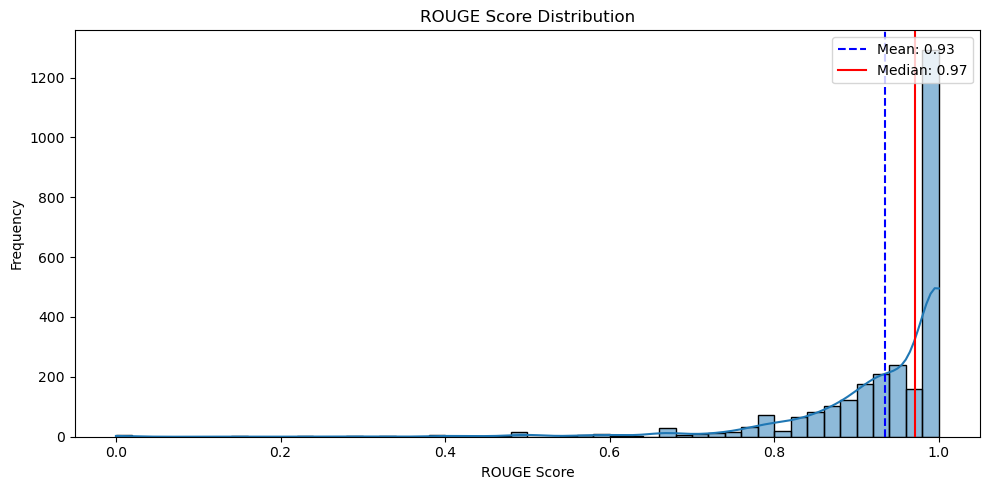

In [33]:
# histogram of rouge scores
plt.figure(figsize=(10, 5))
sns.histplot(data['rouge_score'], bins=50, kde=True)
plt.axvline(data['rouge_score'].mean(), color='blue', linestyle='--', label=f'Mean: {data["rouge_score"].mean():.2f}')
plt.axvline(data['rouge_score'].median(), color='red', linestyle='-', label=f'Median: {data["rouge_score"].median():.2f}')
plt.title('ROUGE Score Distribution')
plt.xlabel('ROUGE Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

# 4. Named Entity Recognition

In [34]:
# combine audio text
data['group_key'] = data['file'].apply(lambda x: '/'.join(x.split('/')[-3:-1]))
data['file_num'] = data['file'].apply(lambda x: int(x.split('/')[-1].split('.')[0].split('-')[-1]))
df_sorted = data.sort_values(by=['group_key', 'file_num'])

combined_text = df_sorted.groupby('group_key')['cleaned_whisper_text'].apply(lambda texts: ' '.join(texts)).reset_index()
combined_text.columns = ['folder_path', 'combined_cleaned_whisper_text']
combined_text.head()

,folder_path,combined_cleaned_whisper_text
0,1272/128104,mr quilter is the apostle of the middle classes and we are glad to welcome his gospel nor is mr quilters manner less interesting than his matter he tells us that at this festive season of the year with christmas and roast beef looming before us similarly drawn from eating and its results occur most readily to the mind he has graved doubts whether sir frederick laytons work is really greek after all and can discover in it but little of rocky ithaca lynelles pictures are a sort of upgards and atom paintings and masons exquisite ittles are as national as a jingo poem mr birkett fosters landscapes smile at one much in the same way that mr carker used to flash his teeth and mr john collier gives his sitter a cheerful slap on the back before he says like a shampoo or a turkish bath next man it is obviously unnecessary for us to point out how luminous these criticisms are how delicate in expression on the general principles of art and mr krilter writes with equal lucidity painting he tells us is of a different quality to mathematics and finish in art is adding more factor as for etchings there are two kinds british and foreign he laments most bitterly the divorce that has been made between decorative art and what we usually call pictures mixed a customary appeal to the last judgment and reminds us that in the great days of art michelangelo was the furnishing upholsterer near the fire and the ornaments fred brought home from india on the mental board in fact he is quite severe on mr ruskin for not recognizing that a picture should denote the frailty of man and remarks with pleasing courtesy and felicitous grace that many phases were feeling only unfortunately his own work never does get good mr quilter has missed his chance for he has failed even to make himself the tupper of painting by harry quilter ma
1,1272/135031,because you were sleeping instead of conquering the lovely rose princess has become a fiddle without a bow while poroshaegi sits there accuing dove he has gone and gone for good answered polychrome who had managed to squeeze into the room beside the dragon and had witnessed the occurrences with much interest i have remained a prisoner only because i wish to be one and with this he stepped forward and burst the stout chains as easily as if they had been threads the little girl had been asleep but she heard the raps and opened the door the king is flooded disgrace and your friends are asking for you i begged ruggedo a long ago to send him away but he would not do so i also offered to help your brother to escape but he would not go he eats and sleeps very steadily replay the nooking i hope he doesnt work too hard since shaggy he doesnt work at all in fact there is nothing he can do in these dominions as well as our norms whose numbers are so great that it worries us to keep them all busy not exactly weve turned calico where is my brother now in quarered shaggy in the metal forest where is that the middle forest is in the great donde cavern the largest in all our dominions replied calico calago hesitated however if we look sharp we may be able to discover one of these secret ways oh no im quite sure he didnt thats funny remarked betsy thoughtfully i dont believe ann knew any magic or shed have worked it before i do not know confess to shaggy true agreed calico calico went to the big gong and pounded on it just as regular used to do but no one answered the summons having returned to the royal cavern calico first pounded the gong and then sat in the throne wearing reggados discarded ruby crown and holding in his hand the scepter which reggato had so often thrown at his head
2,1272/141231,a man said to the universe sir i exist sweatcovered brians body trickling into the titling class that was the only girl in the world the cut on his chest is still dripping blood the ache of his overstrained eyes even the soaring arena around him with the thousands of spectators retrieval

In [35]:
# use a transformer-based NER model
nlp = spacy.load("en_core_web_trf")

def extract_named_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

In [36]:
combined_text['named_entities'] = combined_text['combined_cleaned_whisper_text'].apply(extract_named_entities)

In [37]:
combined_text.head(5)

,folder_path,combined_cleaned_whisper_text,named_entities
0,1272/128104,mr quilter is the apostle of the middle classes and we are glad to welcome his gospel nor is mr quilters manner less interesting than his matter he tells us that at this festive season of the year with christmas and roast beef looming before us similarly drawn from eating and its results occur most readily to the mind he has graved doubts whether sir frederick laytons work is really greek after all and can discover in it but little of rocky ithaca lynelles pictures are a sort of upgards and atom paintings and masons exquisite ittles are as national as a jingo poem mr birkett fosters landscapes smile at one much in the same way that mr carker used to flash his teeth and mr john collier gives his sitter a cheerful slap on the back before he says like a shampoo or a turkish bath next man it is obviously unnecessary for us to point out how luminous these criticisms are how delicate in expression on the general principles of art and mr krilter writes with equal lucidity painting he tells us is of a different quality to mathematics and finish in art is adding more factor as for etchings there are two kinds british and foreign he laments most bitterly the divorce that has been made between decorative art and what we usually call pictures mixed a customary appeal to the last judgment and reminds us that in the great days of art michelangelo was the furnishing upholsterer near the fire and the ornaments fred brought home from india on the mental board in fact he is quite severe on mr ruskin for not recognizing that a picture should denote the frailty of man and remarks with pleasing courtesy and felicitous grace that many phases were feeling only unfortunately his own work never does get good mr quilter has missed his chance for he has failed even to make himself the tupper of painting by harry quilter ma,"[(quilter, PERSON), (quilters, PERSON), (this festive season of the year, DATE), (christmas, DATE), (frederick laytons, PERSON), (greek, NORP), (upgards, PERSON), (atom, PERSON), (masons, PERSON), (birkett, PERSON), (carker, PERSON), (john collier, PERSON), (turkish, NORP), (krilter, PERSON), (two, CARDINAL), (british, NORP), (the great days, DATE), (michelangelo, PERSON), (fred, PERSON), (india, GPE), (the mental board, ORG), (ruskin, PERSON), (quilter, PERSON), (harry quilter ma, PERSON)]"
1,1272/135031,because you were sleeping instead of conquering the lovely rose princess has become a fiddle without a bow while poroshaegi sits there accuing dove he has gone and gone for good answered polychrome who had managed to squeeze into the room beside the dragon and had witnessed the occurrences with much interest i have remained a prisoner only because i wish to be one and with this he stepped forward and burst the stout chains as easily as if they had been threads the little girl had been asleep but she heard the raps and opened the door the king is flooded disgrace and your friends are asking for you i begged ruggedo a long ago to send him away but he would not do so i also offered to help your brother to escape but he would not go he eats and sleeps very steadily replay the nooking i hope he doesnt work too hard since shaggy he doesnt work at all in fact there is nothing he can do in these dominions as well as our norms whose numbers are so great that it worries us to keep them all busy not exactly weve turned calico where is my brother now in quarered shaggy in the metal forest where is that the middle forest is in the great donde cavern the largest in all our dominions replied calico calago hesitated however if we look sharp we may be able to discover one of these secret ways oh no im quite sure he didnt thats funny remarked betsy thoughtfully i dont believe ann knew any magic or shed have worked it before i do not know confess to shaggy true agreed calico calico went to the big gong and pounded on it just as regular used to do but no one answered the summons ha

In [38]:
# save csv
combined_text.to_csv("data/combined_text.csv", index=False)